In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!pip install -r requirements.txt
!pip install --upgrade bitsandbytes
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 kB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 137.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# %cd /content/drive/MyDrive/fine_tune_llms/Llama-3.2-11B-Vision/

from huggingface_hub import login
import json

with open("config.json", "r") as config_file:
    config = json.load(config_file)
    access_token = config["HF_ACCESS_TOKEN"]

login(token=access_token)

## 1. Custom data collator

In [4]:
import copy
import itertools
import torch
from datasets import load_dataset


# check system prompt token seq or user prompt token seq is in the current token list
def check_header(targets, seq):
    for i in range(len(seq) - 3):
        if seq[i : i + 3] in targets:
            return True
    return False


def replace_target(target, seq):
    for i in range(len(seq) - 3):
        if seq[i : i + 3] == target:
            seq[i], seq[i + 1], seq[i + 2] = -100, -100, -100
    return seq

# note the image is not provided in the prompt its included as part of the "processor"
prompt= """Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

##PRODUCT NAME##: {product_name}
##CATEGORY##: {category}"""

system_message = "You are an expert product description writer for Amazon."


# Convert dataset to OAI messages
def format_data(sample):
    formatted_prompt=prompt.format(product_name=sample["Product Name"], category=sample["Category"])
    description=sample["description"]
    
    formatted_prompt=("<|begin_of_text|>"
            f"<|start_header_id|>system<|end_header_id|>{system_message}<|eot_id|>"
            f"<|start_header_id|>user<|end_header_id|>{formatted_prompt}<|image|><|eot_id|>"
            f"<|start_header_id|>assistant<|end_header_id|>{description}<|eot_id|><|end_of_text|>"
    )
    return formatted_prompt


def get_custom_dataset(split_ratio=0.95):
    dataset_dict = load_dataset("philschmid/amazon-product-descriptions-vlm", split="train")
    # 95% train + 5% test
    dataset_dict=dataset_dict.train_test_split(test_size=1-split_ratio,shuffle=True,seed=42)
    # get train and test set
    ds_train, ds_test=dataset_dict['train'], dataset_dict['test']
    return ds_train, ds_test


def tokenize(texts, images, processor):
    # texts = format_data(samples)
    text_prompt=[prompt.replace('<|begin_of_text|>','') for prompt in texts]
    batch=processor(images=images, text=text_prompt, padding=True, return_tensors="pt")

    label_list=[]
    for i in range(len(batch['input_ids'])):
        dialog_tokens=batch["input_ids"][i].tolist()
        labels=copy.copy(dialog_tokens)
        eot_indices=[i for i,n in enumerate(labels) if n==128009]
        last_idx=0

        # system prompt header "<|start_header_id|>system<|end_header_id|>" is tokenized to [128006, 9125, 128007]
        #        user prompt header "<|start_header_id|>user<|end_header_id|>" is tokenized to [128006, 882, 128007]
        prompt_header_seqs = [[128006, 9125, 128007], [128006, 882, 128007]]
        for _,idx in enumerate(eot_indices):
            current_seq=labels[last_idx:idx+1] # current_seq = last_idx to eot_idx
            if check_header(prompt_header_seqs, current_seq):
              # found prompt header -> mask this sequence
              labels[last_idx:idx+1]=[-100]*(idx-last_idx+1)
            else:
              last_idx=idx+1
        #  Mask all the assistant header prompt <|start_header_id|>assistant<|end_header_id|> = [128006, 78191, 128007]
        assistant_header_seq = [128006, 78191, 128007]
        labels=replace_target(assistant_header_seq, labels)

        # Mask the padding token and image token 128256
        for i in range(len(labels)):
            if labels[i]==processor.tokenizer.pad_token_id or labels[i]==128256:
              labels[i]=-100  #  128256 is image token index

        label_list.append(labels)
    batch["labels"]=torch.tensor(label_list)
    return batch


class DataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.processor.tokenizer.padding_side="right"

    def __call__(self,samples):
        # sample = [text,image] with text = list of dict, each having keys "user", "assistant", "source"
        formatted_texts, images=[], []
        for sample in samples:
            # extract formatted text and images
            image=sample["image"]
            formatted_text=format_data(sample)
            image=image.convert("RGB")
            # append text and image
            formatted_texts.append(formatted_text)
            images.append(image)
        return tokenize(formatted_texts, images, self.processor)

def get_data_collator(processor):
    return DataCollator(processor)



In [5]:
# download data
ds_train, ds_test=get_custom_dataset()
ds_train[0]

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=323x500>,
 'Uniq Id': '7090496af34220809e65bb610cefb2d0',
 'Product Name': 'Tavern Masters - Tavern Menu Deck (Tavern Masters Exp.)',
 'Category': 'Toys & Games | Games & Accessories',
 'Selling Price': '$24.99',
 'Model Number': 'DAK0003018',
 'About Product': 'Make sure this fits by entering your model number. | Alternate rules & play styles to mix and match.',
 'Product Specification': 'ProductDimensions:2.7x0.6x4.3inches|ItemWeight:1.28ounces|ShippingWeight:1.6ounces(Viewshippingratesandpolicies)|ASIN:B081G1PNSN|Itemmodelnumber:DAK0003018|Manufacturerrecommendedage:10yearsandup',
 'Technical Details': 'Go to your orders and start the return Select the ship method Ship it! | Go to your orders and start the return Select the ship method Ship it! | show up to 2 reviews by default Alternate rules & play styles to mix and match. Made in the USA. | 1.6 ounces (View shipping rates and policies)',
 'Shipping Weight': '1.6 oun

## 2. Download model and train with peft

In [6]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# load model
model_id="meta-llama/Llama-3.2-11B-Vision"
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model=AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    token=access_token)

processor=AutoProcessor.from_pretrained(model_id,token=access_token)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-01-16 12:22:29.793611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 12:22:29.793721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 12:22:29.887372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 12:22:30.074100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 12:22:31.885431: W tensorflow/compiler/tf2

config.json:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [7]:
from peft import LoraConfig
from trl import SFTConfig


peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=8,
        bias="none",
        target_modules=["q_proj", "k_proj", "v_proj"],
        task_type="CAUSAL_LM",
)


args = SFTConfig(
    output_dir="llama-3.2-vlm", # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=2,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # Uses bfloat16 (16-bit)
    tf32=True,                              # Uses TF32 (19-bit) internally for matrix multiplications
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=False,                      # push model to hub
    report_to="none",                       # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

In [8]:
from trl import SFTTrainer


trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    data_collator=DataCollator(processor),
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

# explicitly move model to cuda because lora layers are currently in CPU
trainer.model = trainer.model.cuda()

trainer.train()

/tmp/ipykernel_42/2791230071.py:4: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


[2025-01-16 12:31:18,961] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.426700
20,1.405700
30,1.111200
40,1.028000
50,0.943300
60,0.899000
70,0.883800
80,0.897500
90,0.814300
100,0.795100


TrainOutput(global_step=237, training_loss=0.8956693516501898, metrics={'train_runtime': 7131.5969, 'train_samples_per_second': 0.537, 'train_steps_per_second': 0.033, 'total_flos': 3.992372824587038e+16, 'train_loss': 0.8956693516501898, 'epoch': 2.9890453834115807})

In [9]:
# save model 
trainer.save_model(args.output_dir)

# free the memory 
del model
del trainer
torch.cuda.empty_cache()

## 3. Load trained model and do inference

In [10]:
import torch, copy

from transformers import AutoProcessor, AutoModelForVision2Seq

def load_fine_tune_model(base_model_id="meta-llama/Llama-3.2-11B-Vision", adapter_path="llama-3.2-vlm"):

    processor = AutoProcessor.from_pretrained(base_model_id)
    # Load Model base model
    base_model = AutoModelForVision2Seq.from_pretrained(
      base_model_id,
      device_map="auto",
      torch_dtype=torch.float16
    )
    # Create a deep copy of the base model for fine-tuning
    model_ft = copy.deepcopy(base_model)
    # load lora config
    model_ft.load_adapter(adapter_path) 
    
    return base_model, model_ft, processor

base_model, model_ft, processor=load_fine_tune_model()

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
import requests
from PIL import Image
from io import BytesIO

prompt= """Create a Short Product description based on the provided ##PRODUCT NAME## and ##CATEGORY## and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

##PRODUCT NAME##: {product_name}
##CATEGORY##: {category}"""

system_message = "You are an expert product description writer for Amazon."

def generate(model, sample, processor):
    # sample= dictionary with keys "Product name", "Category", "image"
    formatted_prompt=prompt.format(product_name=sample["Product Name"], category=sample["Category"])
    formatted_prompt=("<|begin_of_text|>"
            f"<|start_header_id|>user<|end_header_id|>{system_message}<|eot_id|>"
            f"<|start_header_id|>user<|end_header_id|>{formatted_prompt}<|image|><|eot_id|>"
            f"<|start_header_id|>assistant<|end_header_id|>"
    )
    image=sample['image']
    # handle the case image is url
    if isinstance(image, str) and image.startswith("https://"):  # If it's an HTTPS URL
        response = requests.get(image)
        response.raise_for_status()  # Raise an error for HTTP errors
        image = Image.open(BytesIO(response.content)).convert("RGB")  # Convert to RGB PIL image

    inputs=processor(images=[image], text=formatted_prompt, padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=150, temperature=0.8,top_p=5.0, do_sample=True)
    #generated_ids = model.generate(**inputs, max_new_tokens=150, temperature=0.8, top_p=1.0, do_sample=True)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]


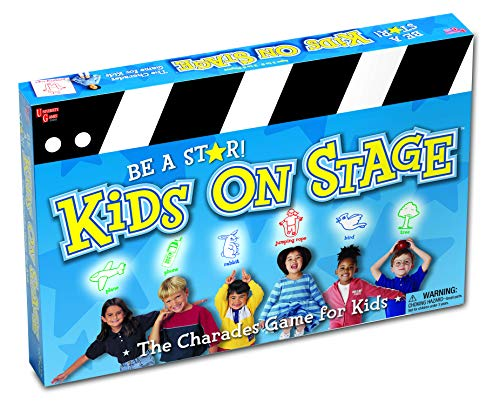

Ground-truth description:
Unleash your child's inner performer with Kids on Stage! This exciting board game brings the thrill of the theater to your family game night.  Develop creativity, teamwork, and quick thinking skills as players collaborate to create and perform the best show. Perfect for ages 6+, fostering imagination and fun for everyone.  Get your tickets now!

Base-model description:
nstantly become a star with the help of the Kids on Stage Charades Game for Kids, the super fun, easy and kid friendly team or family game. Kids on Stage will entertain your child and their friends for hours while also teaching them about acting and speech. It comes with 100 cards featuring a variety of colorful pictures and 55 cards of 8 words for each picture. For ages 6 and up, kids can compete and have fun with their friends and family. They'll love the acting and guessing skills this kids charades game brings out. This game is recommended for 2-6 players and is great for 2-3 players. It inc

In [30]:
from IPython.display import display

# testing from test data
sample=ds_test[0]
display(sample['image'])
print(f"Ground-truth description:\n{sample['description']}\n")

      
# get base description
description_base=generate(base_model, sample, processor)      
print(f"Base-model description:\n{description_base}\n")

# get ft-model description
description_ft=generate(model_ft, sample, processor)      
print(f"Fine-tuned model:\n{description_ft}")


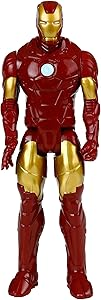

Base model:
n. Marvel's Iron Man figure, part of the Titan Hero Series.\nThis 30.5 cm figure is inspired by the Avengers movie.\nOver 20 points of articulation.\nCollectible Titan Hero Series figures (each sold separately) combine to form a larger-than-life Battle of Titan figure, making this role play the ultimate experience.\nTitan Hero Series figures' 6-inch scale matches that of the 6-inch figures.\nTitan Hero Series figures are designed to be 2x bigger than the standard-sized Marvel Legends figures. Figures sold separately, each sold separately. Colors and decorations may vary. Items sold separately. Some assembly required. No batteries required. Collectible figures inspired by the Avengers movie. Marvel product is intended

Fine-tuned model:
Assemble your Avengers team with this impressive 30.5 cm Iron Man action figure from Hasbro's Marvel Avengers Serie: Titan-Held!  Highly detailed and poseable, this collectible figure is perfect for fans of all ages.  A must-have for any Marv

In [31]:
# testing with sample from amazon.com
sample = {
  "Product Name": "Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur",
  "Category": "Toys & Games | Toy Figures & Playsets | Action Figures",
  "image": "https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg"
}

# Display image
response = requests.get(sample["image"])
image = Image.open(BytesIO(response.content)).convert("RGB")  # Convert to RGB PIL image
display(image)

# get description
base_description=generate(base_model, sample, processor)
ft_description=generate(model_ft, sample, processor)
print(f"Base model:\n{base_description}\n")
print(f"Fine-tuned model:\n{ft_description}")

In [ ]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64
from typing import Union

def compare_generations(image: Union[str, Image.Image], base_description: str, ft_description: str) -> HTML:
    """
    Compare and display image with base and fine-tuned model descriptions.
    
    Args:
        image: Either a URL string or a PIL Image object
        base_description: Description from the base model
        ft_description: Description from the fine-tuned model
    
    Returns:
        IPython.display.HTML: Styled HTML table with image and descriptions
    """
    # Process the image input
    if isinstance(image, str):
        response = requests.get(image)
        pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    elif isinstance(image, Image.Image):
        pil_image = image.convert("RGB")
    else:
        raise ValueError("Image input must be either a URL string or a PIL Image object")

    # Convert PIL image to base64 string
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    # Create HTML img tag
    img_html = f'<img src="data:image/jpeg;base64,{img_str}" style="max-width: 250px;">'

    # Create DataFrame
    df = pd.DataFrame({
        'Input image': [img_html],
        'Base Generation': [base_description],
        'Fine-tuned Generation': [ft_description]
    })

    # Style the DataFrame
    styled_df = df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'border': '1px solid black',
        'padding': '10px',
        'width': '250px',
        'overflow-wrap': 'break-word'
    })

    # Set specific style for the image column
    styled_df.set_properties(subset=['Input image'], **{
        'text-align': 'center',
        'vertical-align': 'middle'
    })

    # Enable HTML rendering for the image column
    styled_df.format({'Input image': lambda x: x})

    # Display the styled DataFrame without index
    return HTML(styled_df.to_html(escape=False, index=False))


compare_generations(sample['image'], base_description, ft_description)